In [1]:
import sys
import os 

repo_root = os.path.abspath('..')
sys.path.append(repo_root)

from src.utils.database_manager import DatabaseManager
from src.models.boost import RentPricePredictor
from src.models.neural_network import NeuralNetworkRegressor, train_nn, evaluate_nn
from src.models import tf_idf

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')




/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [36]:
plt.rc('font', family='Serif', size=12)
plt.rc('axes', titlesize=14, titleweight='bold')
plt.rc('axes', labelsize=12, titlesize=14)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## ML WORKFLOW

- Prepare Data
    - Retrieve Unit Amenities 
    - TF-IDF
    - Retrieve Pricing and Other Information 
    - Merge 
    - One Hot Encoding
    - Standard Scaler 
- Dimension Reduction
- XG boost hyper paramter tuning
- Model Comparisons with final K fold results test


In [2]:

def retrieve_combined_dataset(city, state_abbr):
    db_manager = DatabaseManager('../apf.db')

    amenities_df = db_manager.retrieve_amenities(city, state_abbr)
    tf_idf_df = tf_idf.get_tf(amenities_df)
    unit_df = db_manager.retrieve_units(city, state_abbr)
    merged_df = pd.merge(tf_idf_df, unit_df, on='UnitId', how='left')
    merged_df['Neighborhood'].replace('', 'Unknown', inplace=True)

    return merged_df



def prepare_data(df):
    # Filter rows with non-null RentPrice values
    df = df[df['RentPrice'].notna()]
    
    # Define categorical and numeric columns
    categorical_columns = ['Neighborhood']  # Add more categorical columns if necessary
    numeric_columns = [col for col in df.columns if col not in ['UnitId', 'RentPrice', 'ModelName', 'Neighborhood']]
    
    # Convert categorical columns to strings
    df[categorical_columns] = df[categorical_columns].astype(str)
    
    # Ensure numeric columns are numeric and replace any non-numeric data with NaN or zeros if necessary
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # One-hot encoding for categorical data and scaling for numeric data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_columns),
            ('cat', OneHotEncoder(drop='first'), categorical_columns)
        ]
    )
    
    # Drop unnecessary columns and separate features and target
    X = df.drop(columns=['UnitId', 'RentPrice', 'ModelName']).fillna(0.0)
    y = df['RentPrice']
    
    # Apply preprocessing (scaling and one-hot encoding)
    scaled_X = preprocessor.fit_transform(X)
    
    return scaled_X, np.array(y)


In [3]:
df = retrieve_combined_dataset('austin', 'tx')
print(df.head())

8
    UnitId        10  10ft   11   12  120  128   13   14   15  ...  your  \
0  000vnf3  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
1  001g8z2  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
2  001ypl3  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
3  0025j52  0.445509   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
4  0026113  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   

   RentPrice  Beds  Baths  SquareFootage               ModelName  Latitude  \
0     1350.0     1    1.0          729.0                      A3  30.42922   
1     2650.0     2    2.0         1157.0                      B4  30.25503   
2     1250.0     1    1.0          742.0  1 Bedroom One Bathroom  30.33204   
3     1479.0     1    1.0          762.0                     A12  30.47948   
4     2062.0     3    2.0         1367.0                      C1  30.21591   

   Longitude  NumUnits      Neighborhood  
0  -97.69659        45    Sco

In [4]:
scaled_X, y = prepare_data(df)

## Dimension Reduction


find number of components using a scree graph

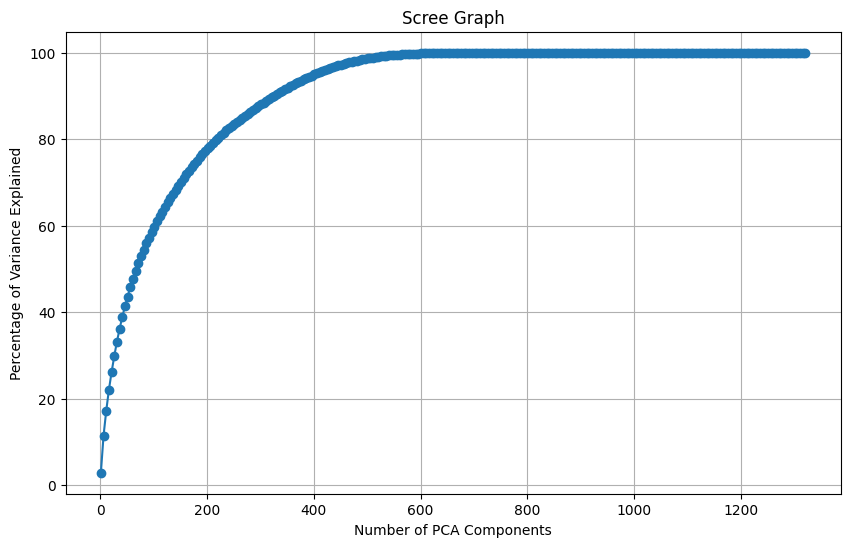

In [5]:

# Initialize PCA and fit the model to the scaled data
pca = PCA()
pca.fit(scaled_X)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
components_tested = np.arange(1, len(cumulative_explained_variance) + 1, 5)
selected_variance = cumulative_explained_variance[components_tested - 1]

plt.figure(figsize=(10, 6))
plt.plot(components_tested, selected_variance * 100, marker='o')
plt.title("Scree Graph")
plt.xlabel("Number of PCA Components")
plt.ylabel("Percentage of Variance Explained")
plt.grid(True)
plt.show()


In [6]:
def dimension_reduction(df, n_components=50):
    pca = PCA(n_components=n_components)
    reduced_df = pca.fit_transform(df)
    return reduced_df

reduced_X = dimension_reduction(scaled_X, n_components=350)

## XG Boost hyper parameter tuning

In [7]:
boost = RentPricePredictor()
best_model, best_params, best_score = boost.tune_xgboost_hyperparameters(reduced_X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


##  K folds validation

In [19]:



repeated_kf = KFold(n_splits=5)

xgboost_model = best_model
xgboost_mse_scores = []
xgboost_predictions = []

nn_mse_scores = []
nn_predictions = []

# Store true values for all test sets
all_test_targets = []

counter = 1
# Loop over each split in the repeated K-Fold
for train_indices, test_indices in repeated_kf.split(reduced_X):
    print(f"Fold: {counter}")
    
    X_train, X_test = reduced_X[train_indices], reduced_X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    all_test_targets.extend(y_test)

    # XGBoost model training and evaluation
    trained_xgboost_model = boost.train_model(xgboost_model, X_train, y_train)
    xgboost_pred = trained_xgboost_model.predict(X_test)
    xgboost_predictions.extend(xgboost_pred)
    xgboost_mse = boost.evaluate_model(trained_xgboost_model, X_test, y_test)
    xgboost_mse_scores.append(xgboost_mse)

    # Neural Network model training and evaluation
    trained_nn_model = train_nn(X_train, y_train)
    nn_mse, nn_pred = evaluate_nn(trained_nn_model, X_test, y_test)
    nn_predictions.extend(nn_pred)
    nn_mse_scores.append(nn_mse)

    counter += 1


average_xgboost_mse = sum(xgboost_mse_scores) / len(xgboost_mse_scores)
average_nn_mse = sum(nn_mse_scores) / len(nn_mse_scores)

print(f"Average XGBoost MSE: {average_xgboost_mse}")
print(f"Average Neural Network MSE: {average_nn_mse}")




Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Average XGBoost MSE: 72921.52409406951
Average Neural Network MSE: 141020.3734375


Plotting

In [9]:
def plot_mse_distribution(ax, mse_scores):
    ax.hist(mse_scores)
    ax.set_title("Mean Squared Error Across Folds")
    ax.set_xlabel("Distribution of Folds")
    ax.set_ylabel("MSE")

# Function for Actual vs Predicted Scatter Plot
def plot_actual_vs_predicted(ax, y_test, y_pred):
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    ax.set_xlabel("Actual Rent Price")
    ax.set_ylabel("Predicted Rent Price")
    ax.set_title("Actual vs Predicted Rent Prices")




XG BOOST Results

XG BOOST Average MSE: 72921.52409406951


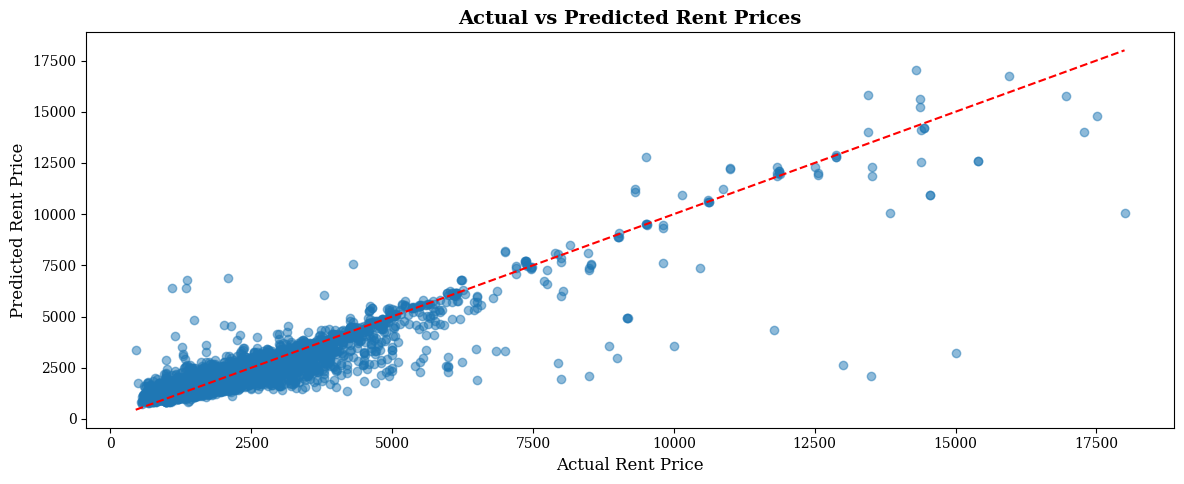

In [39]:
print(f"XG BOOST Average MSE: {average_xgboost_mse}")
fig, ax = plt.subplots(figsize=(12, 5))  

# plot_mse_distribution(ax[0], xgboost_mse_scores)
plot_actual_vs_predicted(ax, all_test_targets, xgboost_predictions)


plt.tight_layout()
plt.savefig('pred')
plt.show()


Neural Network Results 

Neural Network Average MSE: 141020.3734375


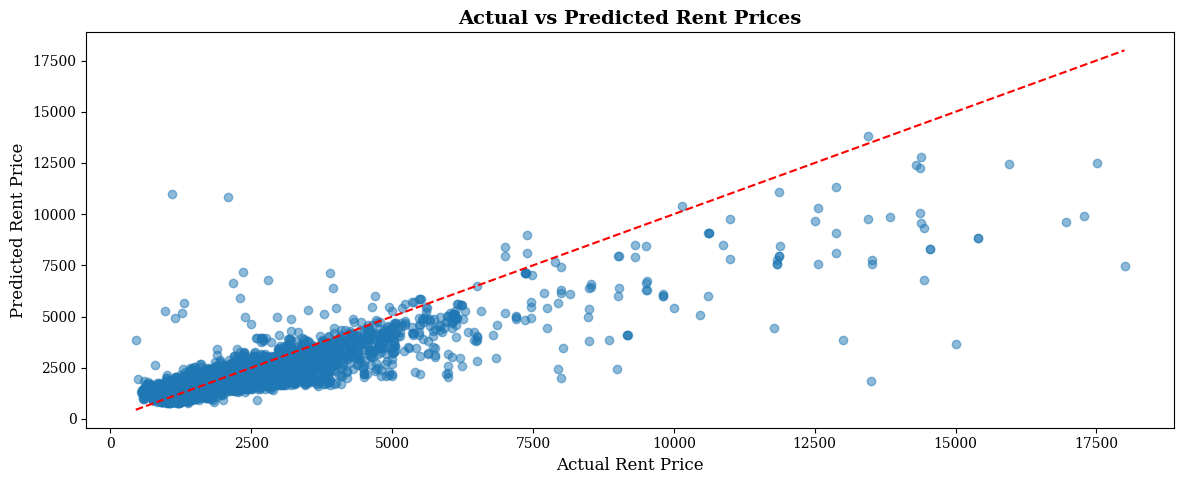

In [38]:
print(f"Neural Network Average MSE: {average_nn_mse}")
fig, ax = plt.subplots( figsize=(12, 5))

# plot_mse_distribution(ax[0], nn_mse_scores)
plot_actual_vs_predicted(ax, all_test_targets, nn_predictions)


plt.tight_layout()
plt.show()

### Comparing to model without text data

In [27]:

# Perform train-test split while keeping indices
X_train, X_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.2, random_state=42)


In [30]:
no_text = df[['RentPrice',  'Beds',  'Baths',  'SquareFootage', 'ModelName',  'Latitude', 'Longitude', 'NumUnits', 'Neighborhood', 'UnitId']]
X_no_text, y_no_text = prepare_data(no_text)

train_indices = np.arange(len(X_train))  
test_indices = np.arange(len(X_train), len(X_train) + len(X_test))

# Use integer-based indexing
X_train_no_text = X_no_text[train_indices] 
X_test_no_text = X_no_text[test_indices]   

# Ensure `y_no_text` remains a Pandas Series for indexing
y_train_no_text = y_no_text[train_indices]  
y_test_no_text = y_no_text[test_indices]    


In [31]:
boost = RentPricePredictor()
best_model1, best_params, best_score = boost.tune_xgboost_hyperparameters(X_train_no_text, y_train_no_text)

boost = RentPricePredictor()
best_model2, best_params, best_score = boost.tune_xgboost_hyperparameters(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [32]:

best_model1.fit(X_train_no_text,y_train_no_text)
best_model2.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=99, ...)

In [35]:


no_text_preds = best_model1.predict(X_test_no_text)
no_text_mse = mean_squared_error(no_text_preds, y_test_no_text)

preds = best_model.predict(X_test)
mse = mean_squared_error(preds, y_test)

percentage_improvement = ((no_text_mse - mse) / no_text_mse) * 100

print(f"No Text: {no_text_mse}")
print(f"With TF-IDF: {mse}")
print(f"Percentage Improvement: {percentage_improvement:.2f}%")

No Text: 40715.55540346175
With TF-IDF: 23941.940384247195
Percentage Improvement: 41.20%
